In [3]:
import torch
import matplotlib
import matplotlib.pyplot as plt

import weight_formats.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

INT4 (Scaled + Offset):  -1.00 -0.87 -0.73 -0.60 -0.47 -0.33 -0.20 -0.07  0.07  0.20  0.33  0.47  0.60  0.73  0.87  1.00
   CRD Normal B=32 Sym:  -1.00 -0.80 -0.64 -0.51 -0.38 -0.27 -0.16 -0.05  0.05  0.16  0.27  0.38  0.51  0.64  0.80  1.00
 Lloyd-Max Normal B=32:  -0.97 -0.77 -0.61 -0.48 -0.36 -0.25 -0.15 -0.05  0.05  0.15  0.26  0.37  0.49  0.62  0.78  0.97
                   NF4:  -1.00 -0.70 -0.53 -0.39 -0.28 -0.18 -0.09  0.00  0.08  0.16  0.25  0.34  0.44  0.56  0.72  1.00
         E2M1 (Scaled):  -1.00 -0.67 -0.50 -0.33 -0.25 -0.17 -0.08 -0.00  0.00  0.08  0.17  0.25  0.33  0.50  0.67  1.00


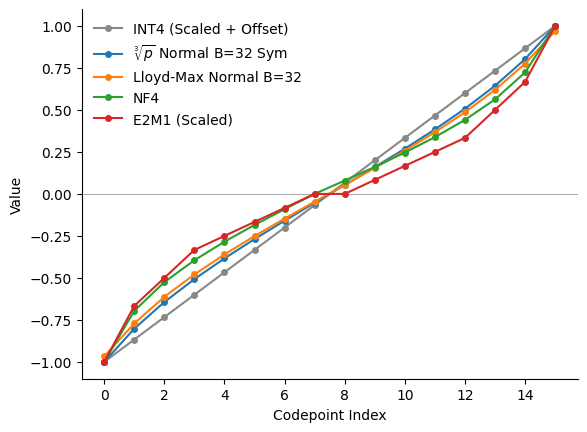

In [ ]:
e2m1 = torch.concat([Q.parse("E2M1").quantise(torch.linspace(-10, 10, 1000)).unique(), torch.tensor([-1e-20])]).sort().values
# e2m1 = Q.parse("E2M1").quantise(torch.linspace(-10, 10, 1000)).unique()
e2m1 /= min(-e2m1.min(), e2m1.max())

int4 = torch.concat([torch.arange(-1, -1/7+1e-6, 1/7), torch.arange(0, 1.0001, 1/8)])
int4 = torch.linspace(-1, 1, 16)

torch.manual_seed(100)
data, _ = Q.block_normalise(torch.randn(2**20, device=DEVICE), (32,), "absmax", (-1, 1), Q.FP32)
lm = Q.lut_lloyd_max(data, 4, 1e-5, init="uniform_minmax").values

_, ax = plt.subplots()
for name, values in [("INT4 (Scaled + Offset)", int4),
                     (r"$\sqrt[3]{p}$ Normal B=32 Sym", Q.crd_block_normal(4, 32, mode="symmetric").values),
                     ("Lloyd-Max Normal B=32", lm),
                     ("NF4", Q.NF4.values),
                     ("E2M1 (Scaled)", e2m1)]:
    print(f"{name.replace(r'$\sqrt[3]{p}$', 'CRD'):>22}: ", " ".join(f"{x:>5.2f}" for x in values))
    ax.plot(values, label=name, marker="o", ms=4, color="#888" if "INT4" in name else None, zorder=-1 if "INT4" in name else None)
ax.legend()
ax.axhline(0, color="k", alpha=.5, lw=0.5, zorder=-2)
ax.set_xlabel("Codepoint Index")
ax.set_ylabel("Value");